## Fraud Detection System
![General Design](https://blog.skymind.ai/content/images/2018/04/gates-1.png)

### Autoencoder
Autoencoder is the unsupervised algorithm in the above picture. While there is a debate as to whether Autoencoder is unsupervised or semi-supervised, I lean towards calling it a semi-supervised algorithm especially for the fraud detection use case. The reason is we need to first know the class of the transactions in order to remove the fraudulant transactions.

![](process.png)

### Setup
We will be using TensorFlow and Keras. Let's begin:

In [38]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping,  TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [39]:
## Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
## Util methods copied from OCAN package due to failure to install as custom package [credit:https://github.com/PanpanZheng/OCAN]
def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])

def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss

def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot

def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])

def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()

## OCAN TF Training Utils
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2

# Loading the data

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [40]:
pwd

'/home/ubuntu/Notebooks/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras'

In [41]:
df = pd.read_csv("data/creditcardfraud.zip", compression='infer', header=0, sep=',', quotechar='"')

# Exploration

In [42]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [43]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [44]:
df.isnull().values.any()

False

In [45]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

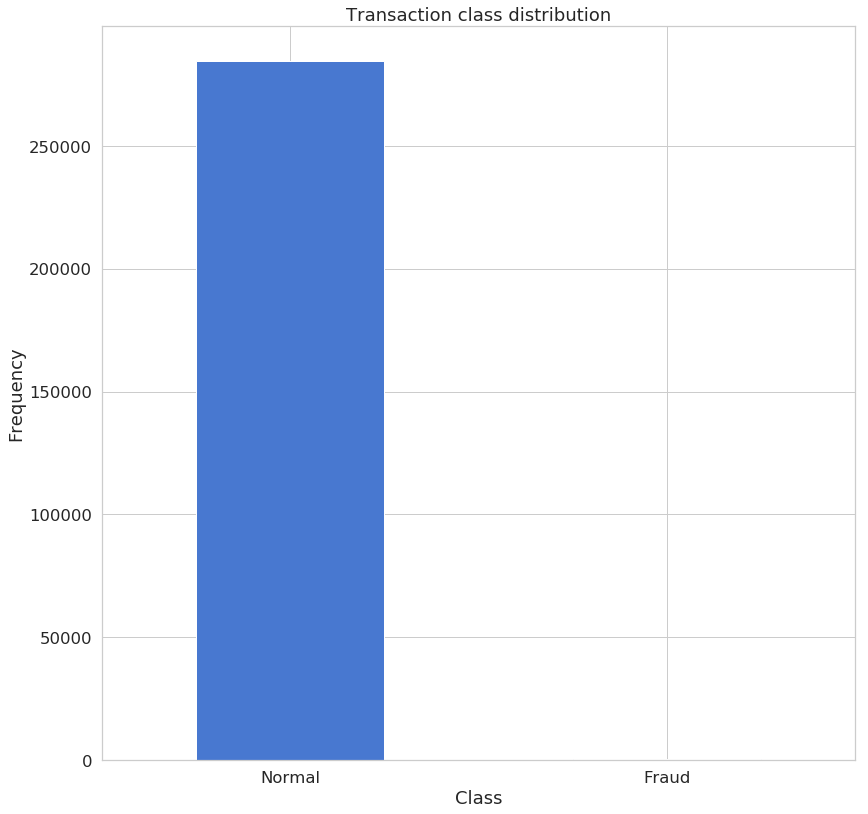

In [46]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [47]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [48]:
frauds.shape

(492, 31)

In [49]:
normal.shape

(284315, 31)

The data is highly imbalanced. Use tnse to visualize the data.

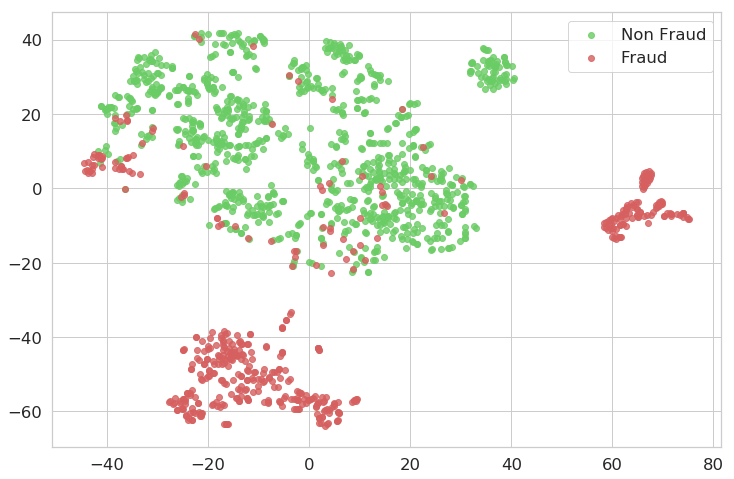

In [50]:
raw_data_sample = df[df['Class'] == 0].sample(1000).append(df[df['Class'] == 1]).sample(frac=1).reset_index(drop=True)
raw_data_x = raw_data_sample.drop(['Class'], axis = 1)
raw_data_x[['Time']]=MinMaxScaler().fit_transform(raw_data_x[['Time']])
raw_data_x[['Amount']]=MinMaxScaler().fit_transform(raw_data_x[['Amount']])
tsne_plot(raw_data_x, raw_data_sample["Class"].values, "raw.png")

How different are the amount of money used in different transaction classes?

In [51]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [52]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

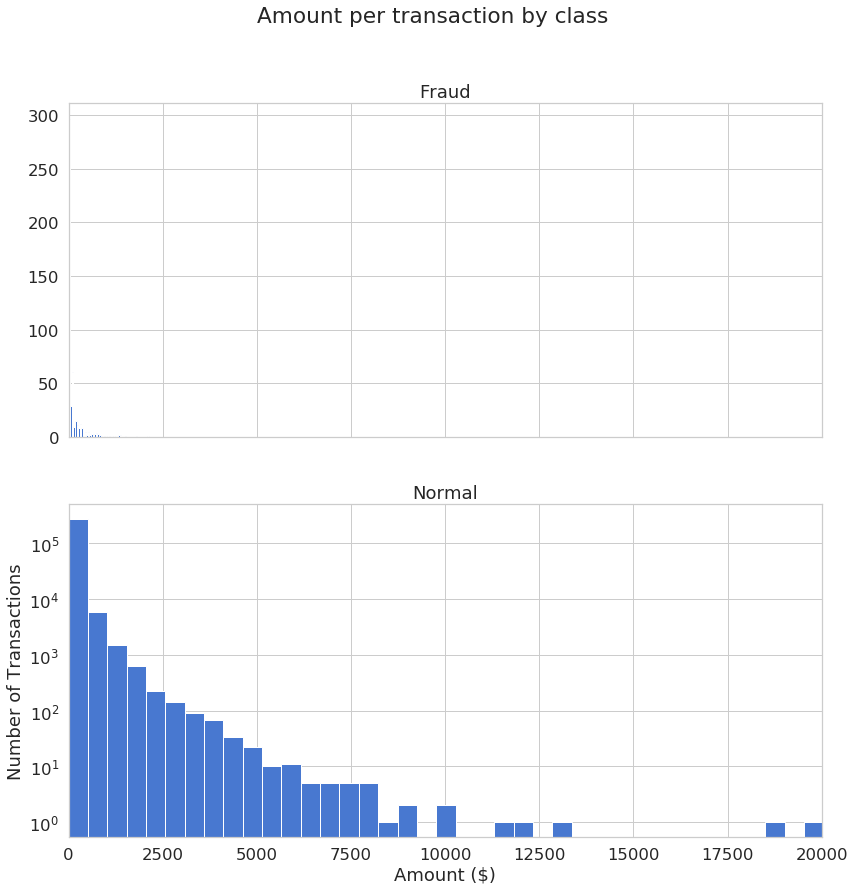

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### Do fraudulent transactions occur more often during certain time?

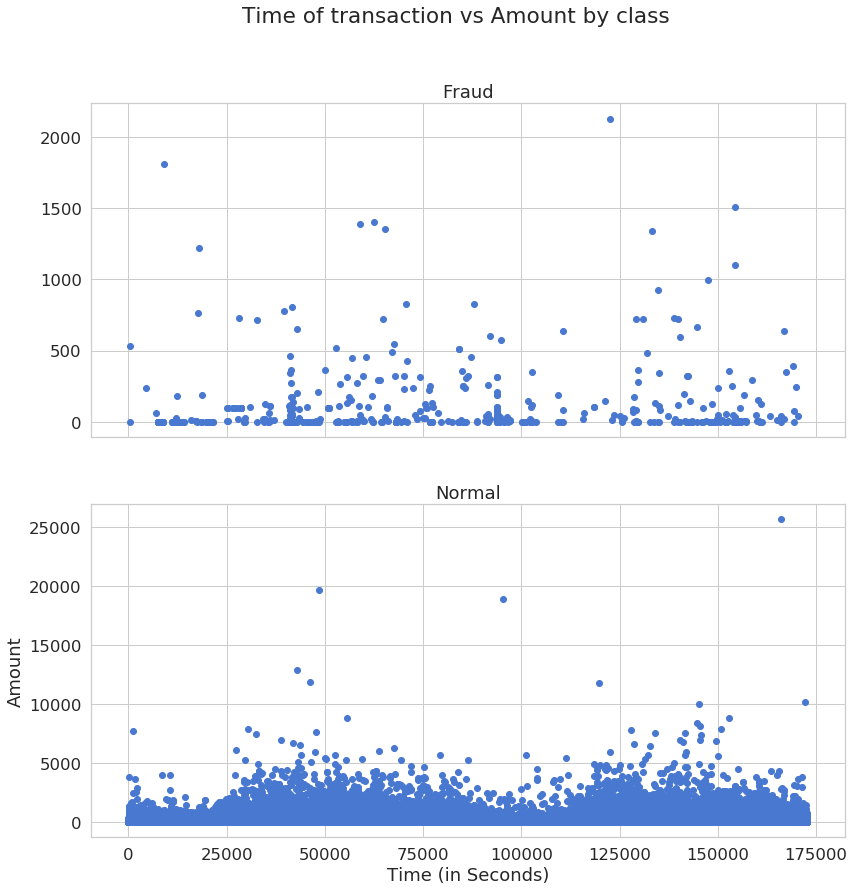

In [54]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.


# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![biycle](https://springml.com/wp-content/uploads/2018/08/screenshot76.jpg)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

<h2 style="background-color: lime; color: green;">
[Autoencoder](https://www.youtube.com/embed/FzS3tMl4Nsc)
</h2>

# Preparing the data

First, 
Do some scaling of Time and Amount columns

In [55]:
#data = df.drop(['Time'], axis=1)

df[['Time']]=MinMaxScaler().fit_transform(df[['Time']])
df.loc[:,'Amount'] = np.log(df['Amount']+1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [56]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0] # this will drop all the fraud transactions
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [57]:
X_train.shape

(227451, 30)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [58]:
class build_and_train_model(object):
    """build and train an autoencoder model"""
    def __init__(self, input_dim, encoding_dim, activations, nb_epoch, batch_size):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.activations = activations
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        
    def build_model(self):
        input_layer = Input(shape=(self.input_dim, ))

        encoder = Dense(self.encoding_dim, activation=self.activations[0], 
                        activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dense(int(self.encoding_dim / 2), activation=self.activations[1])(encoder)

        decoder = Dense(int(self.encoding_dim / 2), activation=self.activations[2])(encoder)
        decoder = Dense(self.input_dim, activation=self.activations[3])(decoder)

        self.autoencoder = Model(inputs=input_layer, outputs=decoder)
        return self.autoencoder

    def train_model(self):
        self.autoencoder.compile(optimizer='adam', 
                            loss='mean_squared_error', 
                            metrics=['accuracy'])

        self.checkpointer = ModelCheckpoint(filepath="model.h5",
                                       verbose=0,
                                       save_best_only=True)
        
        self.earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, 
                                           patience=20, verbose=0,restore_best_weights=True)

        self.tensorboard = TensorBoard(log_dir='./logs',
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=True)

        self.history = autoencoder.fit(X_train, X_train,
                            epochs=self.nb_epoch,
                            batch_size=self.batch_size,
                            shuffle=True,
                            validation_data=(X_test, X_test),
                            verbose=1,
                            callbacks=[self.checkpointer, self.earlystopper, self.tensorboard]).history
        return (self.checkpointer, self.tensorboard, self.history)  

Let's train our model for 10 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

Instead of training for a fixed number of epochs, this autoencoder is trained with early-stopping. The training stops when the validation losses fail to decrease for 20 consecutive epochs.

In [59]:
input_dim = X_train.shape[1]
encoding_dim = 14
activations = ['tanh','relu','tanh','relu']
nb_epoch = 100
batch_size = 32

In [60]:
anc_model = build_and_train_model(input_dim, encoding_dim, activations, nb_epoch, batch_size)
autoencoder = anc_model.build_model()
checkpointer, tensorbord, history = anc_model.train_model()
autoencoder = load_model('model.h5')

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 9s 41us/step - loss: 0.8054 - acc: 0.5445 - val_loss: 0.7902 - val_acc: 0.6066
Epoch 2/100
227451/227451 [==============================] - 9s 40us/step - loss: 0.7418 - acc: 0.6192 - val_loss: 0.7710 - val_acc: 0.6225
Epoch 3/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7328 - acc: 0.6224 - val_loss: 0.7672 - val_acc: 0.6195
Epoch 4/100
227451/227451 [==============================] - 9s 40us/step - loss: 0.7296 - acc: 0.6227 - val_loss: 0.7637 - val_acc: 0.6236
Epoch 5/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7277 - acc: 0.6238 - val_loss: 0.7649 - val_acc: 0.6232
Epoch 6/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7263 - acc: 0.6251 - val_loss: 0.7649 - val_acc: 0.6278
Epoch 7/100
227451/227451 [==============================] - 9s 39us/step - loss: 0.7255 - acc: 0.6260 - val_

# Evaluation

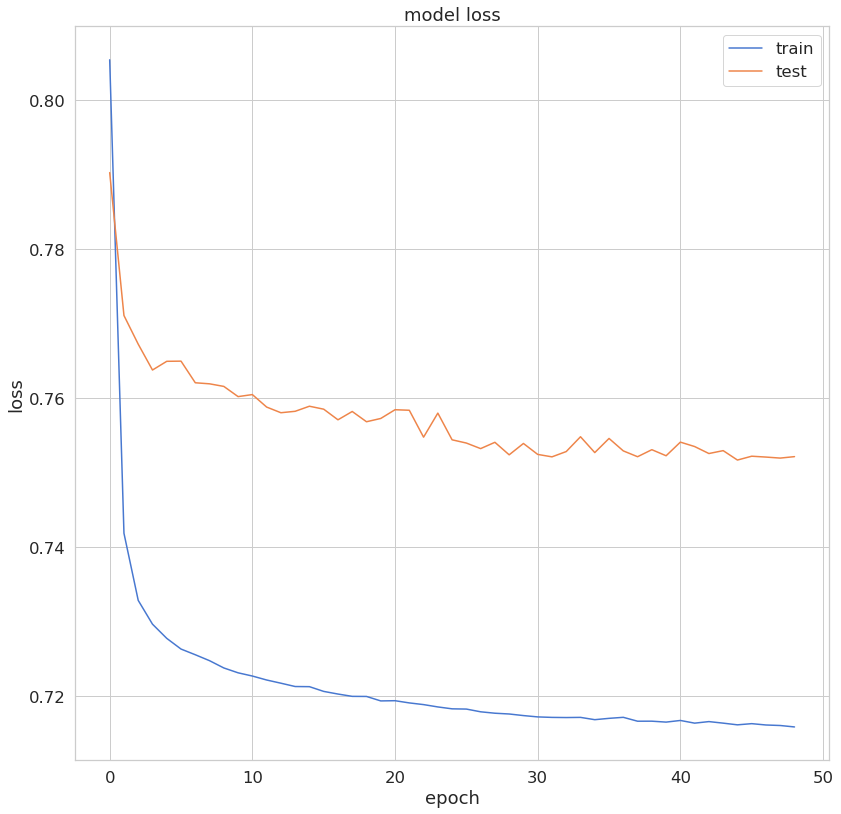

In [61]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [62]:
predictions = autoencoder.predict(X_test) # X_test still has fraud transactions

In [63]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [64]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.743305,0.001720
std,3.295401,0.041443
min,0.057026,0.000000
25%,0.273553,0.000000
50%,0.410126,0.000000
75%,0.635882,0.000000
max,256.910182,1.000000


## Reconstruction error without fraud

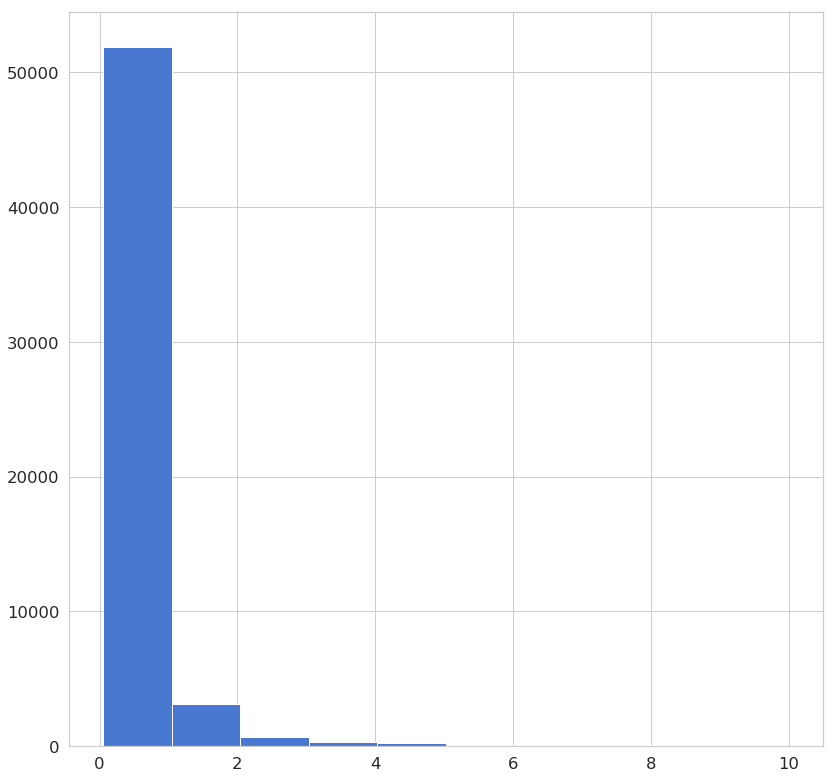

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

For majority of the non-fraud records, the reconstruction error is quite low.

## Reconstruction error with fraud

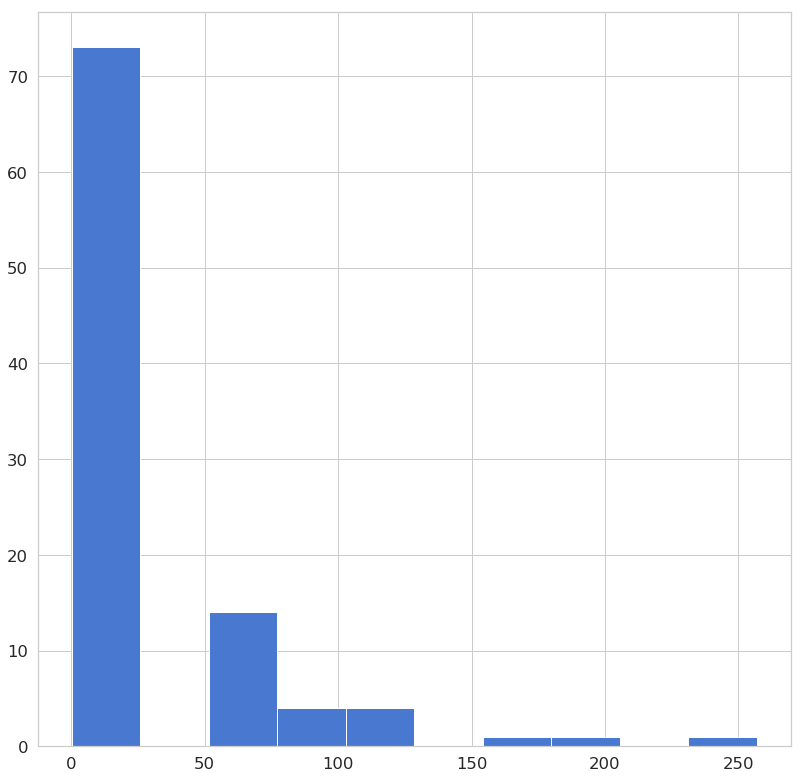

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

For the fraud classes, the reconstruction error is more spread out.

In [67]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

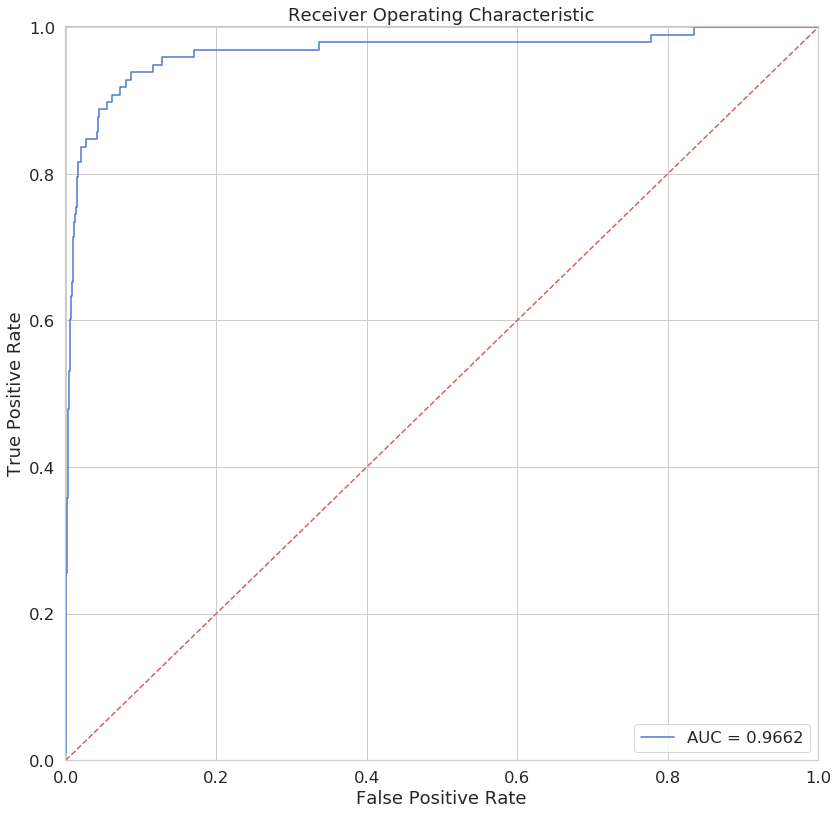

In [68]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

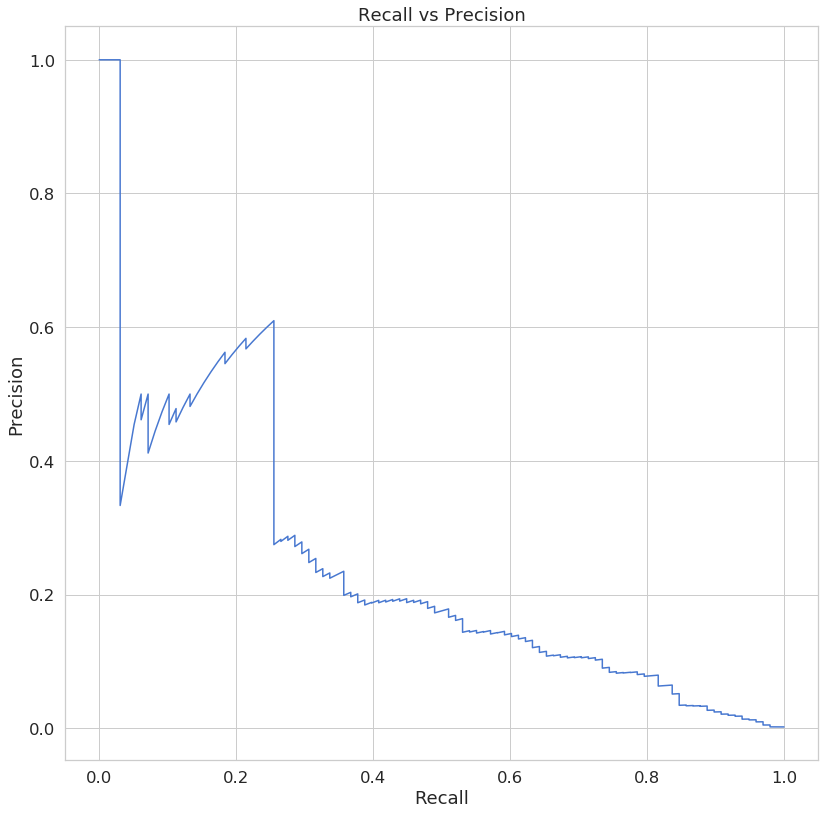

In [69]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

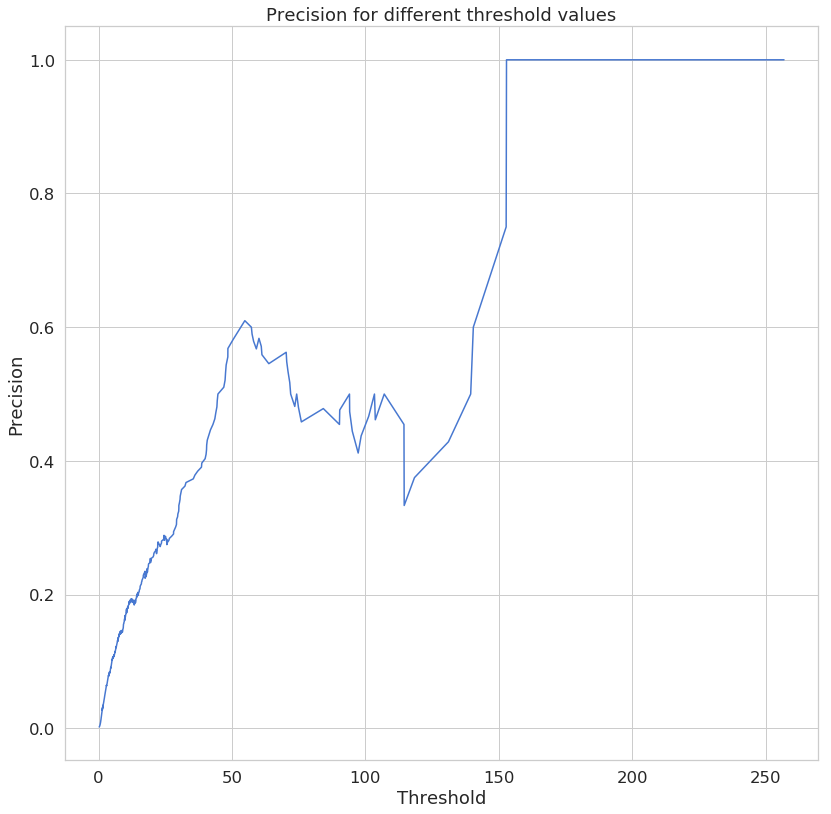

In [70]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

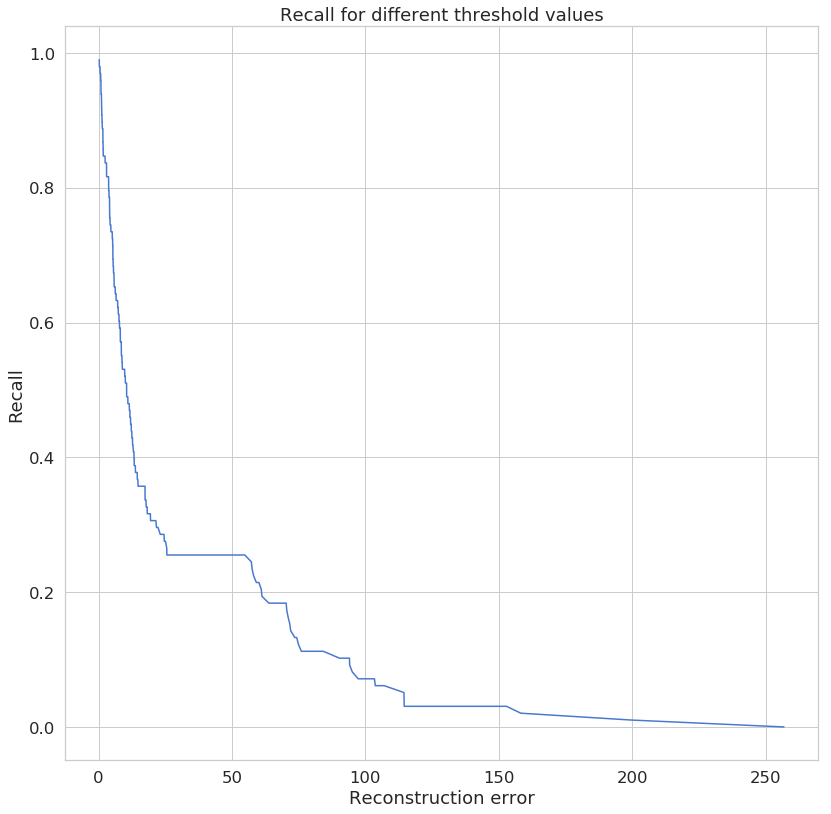

In [71]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

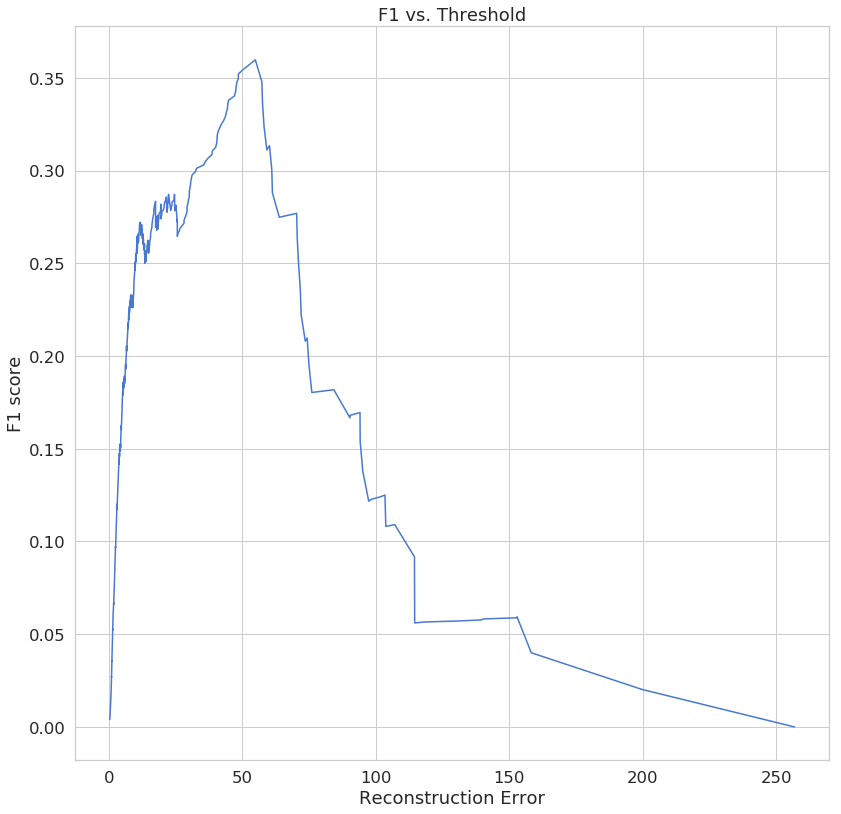

In [72]:
def get_f1(precision,recall):
    return (2*precision*recall)/(precision+recall)


plt.plot(th, get_f1(precision[1:],recall[1:]), 'b', label='F1 curve')
plt.title('F1 vs. Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('F1 score')
plt.show()

In [73]:
f1 = list(get_f1(precision[1:],recall[1:]))
index_of_max_f1 =  np.where(f1==max(f1))
best_f1_th = th[index_of_max_f1]

Let us say that we care about recall more than the precision. Fbeta score will be used when higher (beta times) weight is given to recall as opposed to precision.

$$
F{\beta} = \dfrac{(1+ß²)* Precision  * Recall}{(ß^² * Precision) + Recall}
$$

Let us say that finding frauds is 10 times as important than the additional work required in evaluating the false positives.

In [203]:
beta = 10

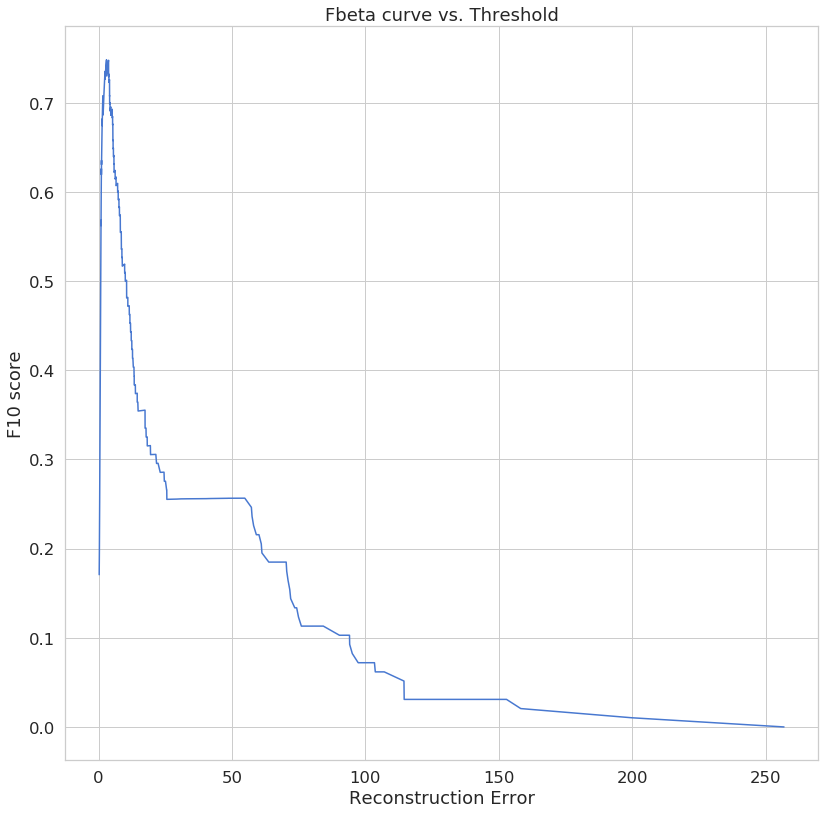

In [204]:
def get_fbeta(precision,recall, beta):
    return ((1+np.square(beta))*precision*recall)/((np.square(beta)*precision)+recall)

label='F'+ 'beta' + ' curve'
plt.plot(th, get_fbeta(precision[1:],recall[1:],beta), 'b', label=label)
plt.title(label + ' vs. Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('F' + str(beta) + ' score')
plt.show()

In [205]:
fbeta = list(get_fbeta(precision[1:],recall[1:], beta))
index_of_max_fbeta =  np.where(fbeta==max(fbeta))
best_fbeta_th = th[index_of_max_fbeta]

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [206]:
#threshold = best_f1_th
threshold = best_fbeta_th

In [207]:
print(threshold)

[2.97467077]


And see how well we're dividing the two types of transactions:

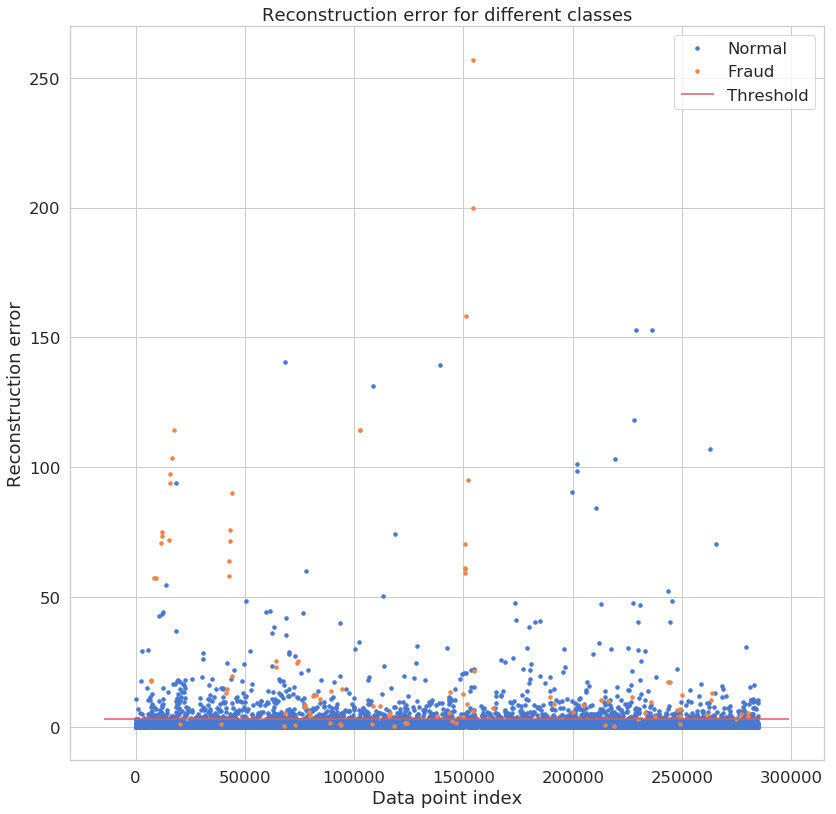

In [208]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

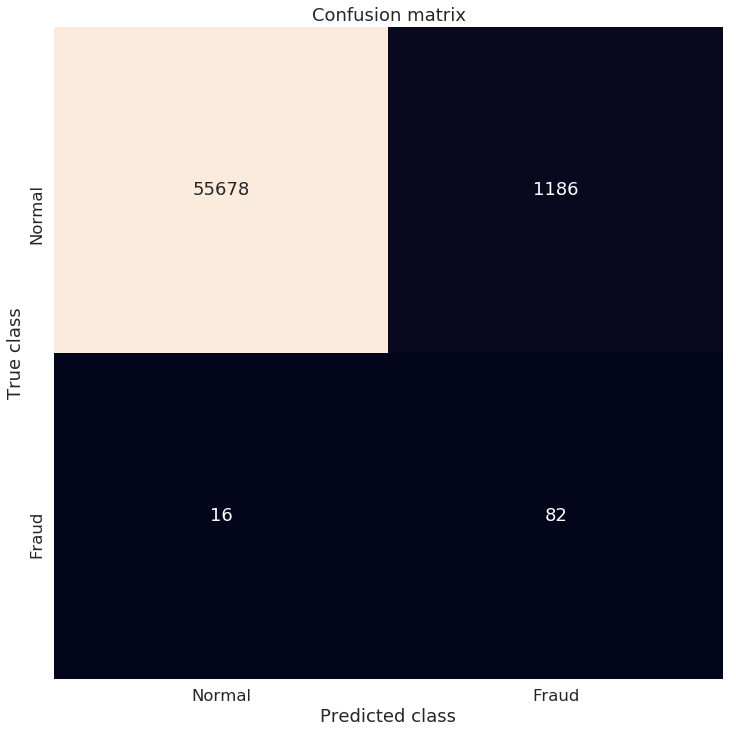

In [209]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cbar=False);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

# Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)